In [3]:
from scipy import signal
from tsfresh import extract_features
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

def convert_to_df(file_loc):
    file = pd.read_csv(file_loc)
    time_series = file.iloc[:,0]
    index_val = list(range(0,len(time_series),2))  
    time_series_50_hz = time_series.iloc[index_val]
    time_series_50_hz = time_series_50_hz.set_axis(range(0,len(time_series_50_hz)))
    time_index = list(range(0,len(time_series_50_hz),1)) 
    time_series_dict = {"Amp":list(time_series_50_hz) , "time": [i*1/50 for i in time_index]}
    time_series_df = pd.DataFrame(time_series_dict)
    return time_series_df

df = '/kaggle/input/data-ascii/Event_ASCII/XA.BHW16..HH.D.2013-01-20T203048.330000.txt'
df = convert_to_df(df)
df

,Amp,time
0,0,0.00
1,0,0.02
2,0,0.04
3,0,0.06
4,0,0.08
...,...,...
27299,0,545.98
27300,0,546.00
27301,0,546.02
27302,0,546.04


In [4]:
def visualize(time_series_df,x_label,y_label):
    plt.plot(time_series_df[x_label],time_series_df[y_label])
    plt.title(f"{y_label} Vs {x_label}")
    plt.xlabel(f"{x_label}")
    plt.ylabel(f"{y_label}")
    plt.show()

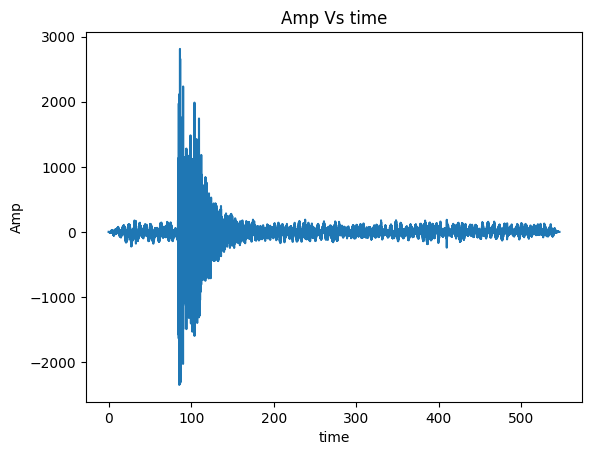

In [5]:
visualize(df,'time','Amp')

## Fourier Transform

In [5]:
def fourier_transform(time_series_df):
    input_signal = time_series_df['Amp']
    sampling_rate = 50
    fft_data = np.fft.fft(input_signal)
    freqs = np.fft.fftfreq(n = len(fft_data), d = 1/sampling_rate)
    fig,ax = plt.subplots()
    ax.plot(freqs,abs(fft_data))
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Spectrum Magnitude')

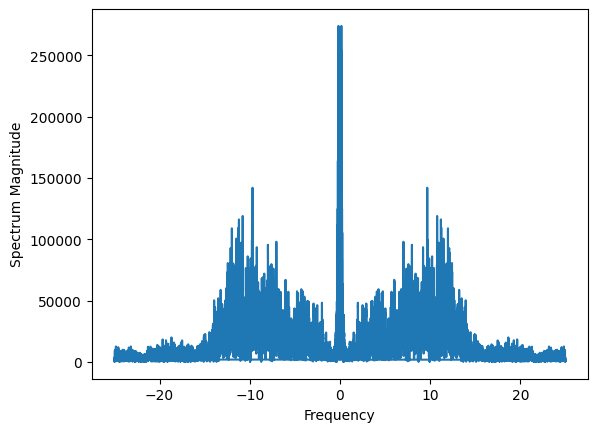

In [7]:
fourier_transform(df)

In [6]:
def fourier_transform_range(time_series_df,lower_freq,upper_freq):
    input_signal = time_series_df['Amp']
    sampling_rate = 50
    fft_data = np.fft.fft(input_signal)
    freqs = np.fft.fftfreq(n = len(fft_data), d = 1/sampling_rate)
    fig,ax = plt.subplots()
    freq_mag_df = pd.DataFrame({'Spectral_Magnitude': abs(fft_data), 'Frequency': freqs})
    true_range = freq_mag_df[freq_mag_df['Frequency']>lower_freq][freq_mag_df['Frequency']<upper_freq]
    ax.plot(true_range['Frequency'],true_range['Spectral_Magnitude'])
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Spectrum Magnitude')

/tmp/ipykernel_33/2486673731.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_range = freq_mag_df[freq_mag_df['Frequency']>lower_freq][freq_mag_df['Frequency']<upper_freq]


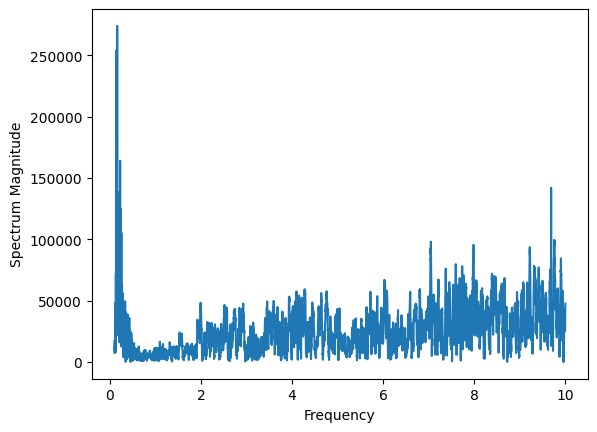

In [7]:
fourier_transform_range(df,0.1,10)

Earthquake frequency of 0.1 to 10 htz used for classification #ref: 'https://ui.adsabs.harvard.edu/abs/2004AGUFM.S31B1050D/abstract'

## Band_pass_filter for range 0.1 Hz to 10 Hz 

In [8]:
def band_pass_filter(time_series_df,lower_freq,upper_freq,sampling_rate):
    input_signal = time_series_df['Amp']
    #low pass filter
    fc = upper_freq
    w = fc/(sampling_rate/2) #normalisation by sampling_rate/2 for critical frequency
    b,a = signal.butter(5,w,'low',analog = False)    # N - order of bandpass filter  
    output = signal.filtfilt(b,a,input_signal)
    
    #high pass filter
    fch = lower_freq
    w = fc/(sampling_rate/2) 
    b,a = signal.butter(5,w,'high',analog = False)    # N - order of bandpass filter
    output = signal.filtfilt(b,a, output)
    
    filtered_df = pd.DataFrame({'fil_amp':output, 'time':time_series_df['time']})
    
    return filtered_df

<Axes: xlabel='time'>

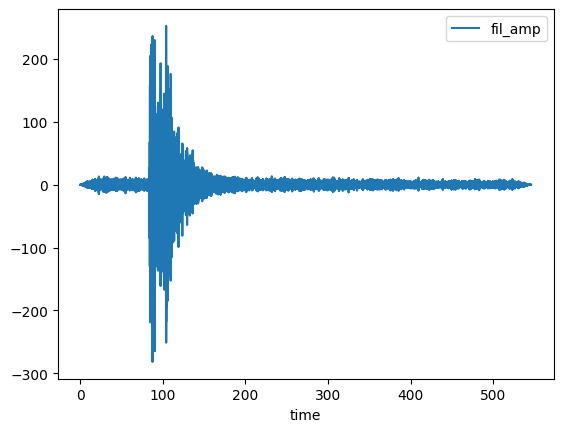

In [9]:
filtered_df = band_pass_filter(df,0.1,10,50)
filtered_df.plot(x='time',y='fil_amp')

## STA/LTA method

#ref: 'https://gfzpublic.gfz-potsdam.de/rest/items/item_4097/component/file_4098/content#:~:text=It%20continuously%20calculates%20the%20average,seismic%20noise%20at%20the%20site.'

In [10]:
def slice_dataframe(fil_df,lower_limit,upper_limit): #lower and upper time limits are used
    sliced_df = df[df['time']>lower_limit][df['time']<upper_limit]
    return sliced_df

def sta_lta_cal(slice_fil_df,LTA,STA):
    size = slice_fil_df['time'].max()
    sta_lta_df = pd.DataFrame(columns = ['Average','Time'])
    j = LTA  # j is used for time of reading in second
    while j<size:
        lta_mean = slice_fil_df['Amp'][slice_fil_df['time']>j-LTA][slice_fil_df['time']<j].abs().mean()
        sta_mean = slice_fil_df['Amp'][slice_fil_df['time']>j-STA][slice_fil_df['time']<j].abs().mean()
        time = j
        sta_lta_average = sta_mean/lta_mean
        sta_lta_df.loc[len(sta_lta_df)] = [sta_lta_average,time]
        j = j+5
    return sta_lta_df

In [11]:
slice_fil_df = slice_dataframe(filtered_df,30,500)

/tmp/ipykernel_33/4194752899.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sliced_df = df[df['time']>lower_limit][df['time']<upper_limit]


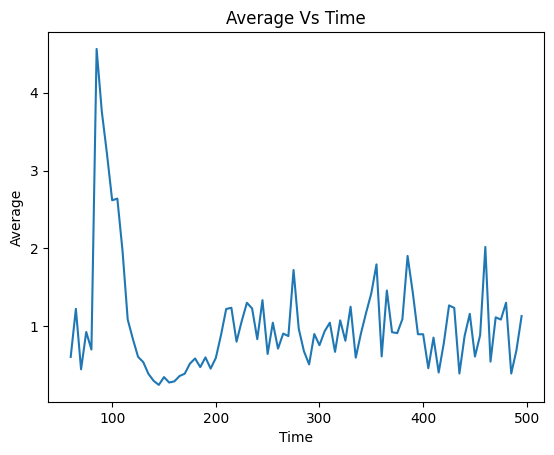

In [12]:
sta_lta_df = sta_lta_cal(slice_fil_df, 60, 2)
visualize(sta_lta_df,'Time','Average')

## Earthquake Interval

In [13]:
def earthquake_noise_interval(sta_lta_df,threshold,interval): #threshold - 2.5 #interval = 1 sec
    ti = 0
    flag = 0
    li = []
    while ti<len(sta_lta_df):
        if sta_lta_df['Average'].iloc[ti] > threshold and flag == 0:
            li.append(sta_lta_df['Time'].iloc[ti])
            flag = 1
        elif sta_lta_df['Average'].iloc[ti]<threshold and flag == 1:
            li.append(sta_lta_df['Time'].iloc[ti])
            li.append('&')
            flag = 0
        ti = ti + interval
    return li

In [14]:
intervals = earthquake_noise_interval(sta_lta_df,2.5,1)
intervals

[85.0, 110.0, '&']

## Feature Extraction 

In [26]:
def feature_extraction(slice_fil_df,intervals,EQ_Nos):
    flag = 0
    for i in range(len(intervals)):
        #extract the time domain time series for intervals of earthquake
        if intervals[i] == '&' or intervals[i+1] == '&':
            continue
        a = intervals[i]
        b = intervals[i+1]
        extracted_interval = slice_fil_df[slice_fil_df['time']>a][slice_fil_df['time']<b]
        
        # add label to the data
        label = [EQ_Nos for x in extracted_interval['time']]
        extracted_interval['label'] = label
        
        # extract features of all the intervals
        j = extracted_interval['time'].min()
        while j<=extracted_interval['time'].max()-1:
            temp_interval = extracted_interval[extracted_interval['time']>j][extracted_interval['time']<j+1]
            feature = extract_features(timeseries_container = temp_interval, column_id = 'label', column_sort = 'time')
            if j == extracted_interval['time'].min() and flag == 0: #write to the external csv file
                feature.to_csv('earthquake_feature_EQ.csv',mode = 'a', header = True)
            else:
                feature.to_csv('earthquake_feature_EQ.csv',mode = 'a', header = False)
            j = j+1
        flag = 1

In [ ]:
import os
folder_to_view = '/kaggle/input/data-ascii/Event_ASCII'
for file in os.listdir(folder_to_view):
    try:
        loc = f"{folder_to_view}/{file}"
        print(loc)
        df = convert_to_df(loc)
        fil_df = band_pass_filter(df,0.1,10,50)
        slice_fil_df = slice_dataframe(fil_df,30,500)
        sta_lta_df = sta_lta_cal(slice_fil_df,60,2)
        intervals = earthquake_noise_interval(sta_lta_df,2.5,1)
        feature_extraction(slice_fil_df,intervals,'EQ')
    except:
        continue

In [29]:
def feature_extraction(slice_fil_df,intervals,EQ_Nos):
    flag = 0
    for i in range(len(intervals)):
        #extract the time domain time series for intervals of earthquake
        if intervals[i] == '&' or intervals[i+1] == '&':
            continue
        a = intervals[i]
        b = intervals[i+1]
        extracted_interval = slice_fil_df[slice_fil_df['time']>a][slice_fil_df['time']<b]
        
        # add label to the data
        label = [EQ_Nos for x in extracted_interval['time']]
        extracted_interval['label'] = label
        
        # extract features of all the intervals
        j = extracted_interval['time'].min()
        while j<=extracted_interval['time'].max()-1:
            temp_interval = extracted_interval[extracted_interval['time']>j][extracted_interval['time']<j+1]
            feature = extract_features(timeseries_container = temp_interval, column_id = 'label', column_sort = 'time')
            if j == extracted_interval['time'].min() and flag == 0: #write to the external csv file
                feature.to_csv('earthquake_feature_Nos.csv',mode = 'a', header = True)
            else:
                feature.to_csv('earthquake_feature_Nos.csv',mode = 'a', header = False)
            j = j+1
        flag = 1

In [ ]:
import os
folder_to_view = '/kaggle/input/data-ascii/Noise_ASCII'
for file in os.listdir(folder_to_view):
    try:
        loc = f"{folder_to_view}/{file}"
        print(loc)
        df = convert_to_df(loc)
        fil_df = band_pass_filter(df,0.1,10,50)
        slice_fil_df = slice_dataframe(fil_df,30,500)
        sta_lta_df = sta_lta_cal(slice_fil_df,60,2)
        intervals = earthquake_noise_interval(sta_lta_df,2.5,1)
        feature_extraction(slice_fil_df,intervals,'Nos')
    except:
        continue

In [31]:
data_earthquake = pd.read_csv("/kaggle/working/earthquake_feature_EQ.csv")
data_noise = pd.read_csv('/kaggle/working/earthquake_feature_Nos.csv')
df_merged = pd.concat([data_earthquake,data_noise],ignore_index = True)
df_merged = df_merged.iloc[np.random.permutation(len(df_merged))]
df_merged = df_merged.reset_index()
df_merged.to_csv('Merged_features.csv')

In [32]:
df_merged

,index,Unnamed: 0,Amp__variance_larger_than_standard_deviation,Amp__has_duplicate_max,Amp__has_duplicate_min,Amp__has_duplicate,Amp__sum_values,Amp__abs_energy,Amp__mean_abs_change,Amp__mean_change,...,Amp__fourier_entropy__bins_5,Amp__fourier_entropy__bins_10,Amp__fourier_entropy__bins_100,Amp__permutation_entropy__dimension_3__tau_1,Amp__permutation_entropy__dimension_4__tau_1,Amp__permutation_entropy__dimension_5__tau_1,Amp__permutation_entropy__dimension_6__tau_1,Amp__permutation_entropy__dimension_7__tau_1,Amp__query_similarity_count__query_None__threshold_0.0,Amp__mean_n_absolute_max__number_of_maxima_7
0,1918,Nos,1.0,0.0,0.0,1.0,-1314660.0,35526807014.0,2823.0833333333335,65.29166666666667,...,0.7113864571354167,0.8222900060250078,1.8388353838849916,1.7430300754376464,2.6442132089297026,3.4329073252455986,3.721176253867357,3.7612001156935624,NaN,30483.14285714286
1,1541,EQ,1.0,0.0,0.0,1.0,231377.0,1092564403.0,2.125,0.7916666666666666,...,0.167944147734173,0.167944147734173,0.8159205766961422,1.4432993243231387,2.3040600758996184,3.050062837551261,3.532136113714645,3.7612001156935624,NaN,4739.142857142857
2,265,EQ,1.0,0.0,0.0,1.0,-11130.0,2557738.0,6.833333333333333,-1.2083333333333333,...,0.167944147734173,0.167944147734173,1.257133793549772,1.7138261416616223,2.5968193152463703,3.4137285204154804,3.658162873816453,3.728960711946588,NaN,262.85714285714283
3,1732,EQ,1.0,0.0,0.0,1.0,-23452.0,11636746.0,63.8125,-3.1875,...,0.2787693717685874,0.6060252027357298,2.3588312796387347,1.7852606260578838,2.8735436802310383,3.4753416031319198,3.6266561837910025,3.696721308199614,NaN,617.7142857142857
4,151,EQ,1.0,0.0,0.0,0.0,-2522.0,32552298.0,832.5833333333334,13.583333333333334,...,0.8950711356531978,1.026904610293371,1.867819515055849,1.6984983185215143,2.5818042039727707,3.2424531540025976,3.59514949376555,3.696721308199614,NaN,1448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,1621,EQ,1.0,0.0,0.0,1.0,-8011.0,22372763.0,867.9583333333334,8.458333333333334,...,0.9704031684231538,1.4414879634298365,2.698879929114458,1.7771751897622325,2.937174870571829,3.51777588101824,3.784189633918262,3.7612001156935624,NaN,1281.2857142857142
2188,460,EQ,1.0,0.0,0.0,1.0,-4202.0,384036.0,12.270833333333334,1.2708333333333333,...,0.33422114621338295,0.6060252027357298,1.890358138098624,1.7460800129277025,2.903680514168427,3.560210158904561,3.721176253867357,3.7612001156935624,NaN,122.57142857142857
2189,1243,EQ,1.0,0.0,0.0,1.0,-6842.0,8234658.0,372.3125,22.770833333333332,...,1.0386495367023671,1.6223136327644068,2.886165178199427,1.7741252522721762,2.8621687205839828,3.4445350617737,3.614764180523626,3.728960711946588,NaN,743.1428571428571
2190,1174,EQ,1.0,0.0,0.0,1.0,14015.0,4035381.0,21.520833333333332,-1.8125,...,0.6904565313848348,1.216706347275259,2.71980985486504,1.7486977565623796,2.986704101337315,3.54858242237646,3.689669563841905,3.7612001156935624,NaN,325.42857142857144


In [33]:
df_merged = df_merged.drop('index', axis = 1)
df_merged.rename(columns = {'Unnamed: 0':'label'},inplace = True)
df_merged
df_merged.fillna(0)
df_merged.info()

,label,Amp__variance_larger_than_standard_deviation,Amp__has_duplicate_max,Amp__has_duplicate_min,Amp__has_duplicate,Amp__sum_values,Amp__abs_energy,Amp__mean_abs_change,Amp__mean_change,Amp__mean_second_derivative_central,...,Amp__fourier_entropy__bins_5,Amp__fourier_entropy__bins_10,Amp__fourier_entropy__bins_100,Amp__permutation_entropy__dimension_3__tau_1,Amp__permutation_entropy__dimension_4__tau_1,Amp__permutation_entropy__dimension_5__tau_1,Amp__permutation_entropy__dimension_6__tau_1,Amp__permutation_entropy__dimension_7__tau_1,Amp__query_similarity_count__query_None__threshold_0.0,Amp__mean_n_absolute_max__number_of_maxima_7
0,Nos,1.0,0.0,0.0,1.0,-1314660.0,35526807014.0,2823.0833333333335,65.29166666666667,-15.191489361702128,...,0.7113864571354167,0.8222900060250078,1.8388353838849916,1.7430300754376464,2.6442132089297026,3.4329073252455986,3.721176253867357,3.7612001156935624,NaN,30483.14285714286
1,EQ,1.0,0.0,0.0,1.0,231377.0,1092564403.0,2.125,0.7916666666666666,0.06382978723404255,...,0.167944147734173,0.167944147734173,0.8159205766961422,1.4432993243231387,2.3040600758996184,3.050062837551261,3.532136113714645,3.7612001156935624,NaN,4739.142857142857
2,EQ,1.0,0.0,0.0,1.0,-11130.0,2557738.0,6.833333333333333,-1.2083333333333333,0.02127659574468085,...,0.167944147734173,0.167944147734173,1.257133793549772,1.7138261416616223,2.5968193152463703,3.4137285204154804,3.658162873816453,3.728960711946588,NaN,262.85714285714283
3,EQ,1.0,0.0,0.0,1.0,-23452.0,11636746.0,63.8125,-3.1875,0.9361702127659575,...,0.2787693717685874,0.6060252027357298,2.3588312796387347,1.7852606260578838,2.8735436802310383,3.4753416031319198,3.6266561837910025,3.696721308199614,NaN,617.7142857142857
4,EQ,1.0,0.0,0.0,0.0,-2522.0,32552298.0,832.5833333333334,13.583333333333334,-4.223404255319149,...,0.8950711356531978,1.026904610293371,1.867819515055849,1.6984983185215143,2.5818042039727707,3.2424531540025976,3.59514949376555,3.696721308199614,NaN,1448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,EQ,1.0,0.0,0.0,1.0,-8011.0,22372763.0,867.9583333333334,8.458333333333334,16.03191489361702,...,0.9704031684231538,1.4414879634298365,2.698879929114458,1.7771751897622325,2.937174870571829,3.51777588101824,3.784189633918262,3.7612001156935624,NaN,1281.2857142857142
2188,EQ,1.0,0.0,0.0,1.0,-4202.0,384036.0,12.270833333333334,1.2708333333333333,-0.18085106382978725,...,0.33422114621338295,0.6060252027357298,1.890358138098624,1.7460800129277025,2.903680514168427,3.560210158904561,3.721176253867357,3.7612001156935624,NaN,122.57142857142857
2189,EQ,1.0,0.0,0.0,1.0,-6842.0,8234658.0,372.3125,22.770833333333332,5.712765957446808,...,1.0386495367023671,1.6223136327644068,2.886165178199427,1.7741252522721762,2.8621687205839828,3.4445350617737,3.614764180523626,3.728960711946588,NaN,743.1428571428571
2190,EQ,1.0,0.0,0.0,1.0,14015.0,4035381.0,21.520833333333332,-1.8125,0.02127659574468085,...,0.6904565313848348,1.216706347275259,2.71980985486504,1.7486977565623796,2.986704101337315,3.54858242237646,3.689669563841905,3.7612001156935624,NaN,325.42857142857144


In [61]:
for col in df_merged.columns:
    print(f"{col} : {df_merged[col].dtype}")

label : object
Amp__variance_larger_than_standard_deviation : object
Amp__has_duplicate_max : object
Amp__has_duplicate_min : object
Amp__has_duplicate : object
Amp__sum_values : object
Amp__abs_energy : object
Amp__mean_abs_change : object
Amp__mean_change : object
Amp__mean_second_derivative_central : object
Amp__median : object
Amp__mean : object
Amp__length : object
Amp__standard_deviation : object
Amp__variation_coefficient : object
Amp__variance : object
Amp__skewness : object
Amp__kurtosis : object
Amp__root_mean_square : object
Amp__absolute_sum_of_changes : object
Amp__longest_strike_below_mean : object
Amp__longest_strike_above_mean : object
Amp__count_above_mean : object
Amp__count_below_mean : object
Amp__last_location_of_maximum : object
Amp__first_location_of_maximum : object
Amp__last_location_of_minimum : object
Amp__first_location_of_minimum : object
Amp__percentage_of_reoccurring_values_to_all_values : object
Amp__percentage_of_reoccurring_datapoints_to_all_datapoints

In [ ]:
feature = df_merged.drop('label',axis = 1)
lable = df_merged['label']

In [ ]:
for col in feature:
    for i in range(len(feature.index)):
        try:
            feature[col].iloc[i] = float(feature[col].iloc[i])
        except:
            feature[col].iloc[i] = 0

## Training Model

In [ ]:
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder

X = feature
y = lable
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify = y, random_state = 8)

In [ ]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from XGBoost import XGBClassifier

estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective paramenters
]
pipe = Pipeline(steps = estimators)

#hyperparameter search spaces
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001,1.0,prior = 'log-uniform'),
    'clf__subsample': Real(0.5,1.0),
    'clf__colsample_bytree': Real(0.5,1.0),
    'clf__colsample_bynode': Real(0.5,1.0),
    'clf__reg_alpha': Real(0.0,10.0),
    'clf__reg_lambda': Real(0.0,10.0),
    'clf__gamma': Real(0.0,10.0)
}

opt = BayesSearchCV(pip,search_space,cv=3,n_iter=10,scoring = 'roc_auc', random_state = 8)
opt.fit(X_train,y_train)

#Evaluate the model and make predictions
opt.best_estimator_
opt.best_score_
opt.score(X_test,y_test)
opt.predict(X_test)
opt.predict_proba(X_test)